# Beat The Bookie Dataset: Line Movement Analysis

This notebook analyzes line movement in football betting markets by combining Beat-The-Bookie closing odds with Football-Data opening odds. We examine how betting lines shift from opening to closing and analyze the performance of favorites in high-movement matches.

## Table of Contents
1. [Data Preprocessing](#data-preprocessing)
2. [Exploratory Data Analysis (EDA)](#eda)
3. [Hypothesis Testing](#hypothesis-testing)

---

# 1. Data Preprocessing <a id="data-preprocessing"></a>

This section handles data loading, cleaning, and preparation for line movement analysis.

In [1]:
%pip install pandas numpy matplotlib scipy seaborn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All libraries loaded successfully!")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
All libraries loaded successfully!
All libraries loaded successfully!


## 1.1 Library Installation and Setup

We install and configure necessary libraries for data manipulation, visualization, and statistical analysis.

In [2]:
import os
import pandas as pd

data_dir = '/Users/boraberkercansever/Desktop/DSA210/raw/BTB-data'

# File to load
selected_file = 'closing_odds.csv.gz'
file_path = os.path.join(data_dir, selected_file)

print("="*80)
print("Beat the Bookie - Closing Odds Load")
print("="*80)
print(f"\n{selected_file}")
file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
print(f"   File Size: {file_size:.2f} MB")
print("-"*80)

data_files = {}

try:
    # Load CSV.GZ file directly with pandas
    df = pd.read_csv(file_path)
    data_files['closing_odds'] = df
    
    print(f"Loaded")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Data Types:\n{df.dtypes}")
    print(f"\n   First 3 rows:")
    display(df.head(3))
    
    print(f"\n   Missing Values:")
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print(null_counts[null_counts > 0])
    else:
        print("   No missing values!")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*80)
print("Summary")
print("="*80)
print(f"Loaded DataFrames: {list(data_files.keys())}")

Beat the Bookie - Closing Odds Load

closing_odds.csv.gz
   File Size: 18.56 MB
--------------------------------------------------------------------------------
Loaded
   Shape: 479,440 rows × 19 columns
   Columns: ['match_id', 'league', 'match_date', 'home_team', 'home_score', 'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win', 'top_bookie_home_win', 'top_bookie_draw', 'top_bookie_away_win', 'n_odds_home_win', 'n_odds_draw', 'n_odds_away_win']
   Data Types:
match_id                 int64
league                  object
match_date              object
home_team               object
home_score               int64
away_team               object
away_score               int64
avg_odds_home_win      float64
avg_odds_draw          float64
avg_odds_away_win      float64
max_odds_home_win      float64
max_odds_draw          float64
max_odds_away_win      float64
top_bookie_home_win     object
top_book

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9



   Missing Values:
top_bookie_home_win    28
top_bookie_away_win    24
dtype: int64

Summary
Loaded DataFrames: ['closing_odds']


## 1.2 Beat-The-Bookie Data Loading

This section loads the closing odds data from the Beat-The-Bookie dataset, filters for major European leagues (Big Five), and prepares the data for analysis.

In [3]:
import pandas as pd

# Convert match_date to datetime
df['match_date'] = pd.to_datetime(df['match_date'])

# Filter 2009-2015 seasons (2009-08-01 to 2015-06-30)
df_filtered = df[(df['match_date'] >= '2009-08-01') & (df['match_date'] <= '2015-06-30')].copy()

print("Beat the Bookie Data Filteration: 2009-2015 SEASONS")
print("="*60)
print(f"\nOriginal data: {len(df):,} rows")
print(f"Filtered data (2009-2015): {len(df_filtered):,} rows")

# Show available leagues
print("\n")
print("Available Leagues: 2009 to 2015")
print("="*60)
print("\nLeague distribution:")
print(df_filtered['league'].value_counts())

# Define 5 big leagues (with BTB league names)
# NOTE: Spain: La Liga is named "Spain: Primera Division" in BTB
big_five_leagues = [
    'England: Premier League',
    'France: Ligue 1',
    'Germany: Bundesliga',
    'Italy: Serie A',
    'Spain: Primera Division'  # La Liga
]

# Filter to available leagues in BTB dataset
df_big_five = df_filtered[df_filtered['league'].isin(big_five_leagues)].copy()

print(f"\nBIG FIVE LEAGUES FILTERATION")
print("="*80)
print(f"Before big five leagues: {len(df_filtered):,} rows")
print(f"After big five leagues: {len(df_big_five):,} rows")

print("\nBig five leagues distribution (BTB data):")
lig_count = df_big_five['league'].value_counts()
print(lig_count)

print("\nSeason distribution:")
df_big_five['season_year'] = df_big_five['match_date'].dt.year
print(df_big_five.groupby(['league', 'season_year']).size().unstack(fill_value=0))

# Comparison with Football data
print("\n")
print(f"Compatible data in BTB: {lig_count.sum():,} rows")
print(f"\nBTB data successfully filtered for 2009-2015 seasons and big five leagues")
print(f"Variable to use: df_big_five")

Beat the Bookie Data Filteration: 2009-2015 SEASONS

Original data: 479,440 rows
Filtered data (2009-2015): 357,692 rows


Available Leagues: 2009 to 2015

League distribution:
league
World: Club Friendly                13330
World: Friendly International        3956
England: Championship                2786
England: League One                  2785
England: League Two                  2785
                                    ...  
Northern Ireland: Charity Shield        1
China: Yi League                        1
Turkey: TFF 3. Lig Group 5              1
Belgium: 1st National Women             1
Côte d'Ivoire: Ligue 1                  1
Name: count, Length: 800, dtype: int64

BIG FIVE LEAGUES FILTERATION
Before big five leagues: 357,692 rows
After big five leagues: 9,037 rows

Big five leagues distribution (BTB data):
league
England: Premier League    1902
Italy: Serie A             1901
France: Ligue 1            1899
Spain: Primera Division    1899
Germany: Bundesliga        1436
Na

## 1.3 League Selection and Data Filtering

This section filters the data to focus on the Big Five European leagues (England: Premier League, Germany: Bundesliga, Spain: Primera Division, Italy: Serie A, France: Ligue 1) during the 2012-2015 seasons.

In [4]:
# Closing odds columns (Average Odds)
closing_odds_cols = ['home_team', 'away_team', 'match_date', 
                     'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win',
                     'league']

# Select required columns from df_big_five
df_btb_odds = df_big_five[closing_odds_cols].copy()

# Standardize column names
df_btb_odds.columns = ['HomeTeam', 'AwayTeam', 'Date', 
                       'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 
                       'league']

# Date format should be datetime
df_btb_odds['Date'] = pd.to_datetime(df_btb_odds['Date'])

print("Beat the Bookie - Closing Odds Preparation")
print("="*60)
print(f"\nClosing odds data to be used: {len(df_btb_odds):,} rows")
print(f"\nColumns: {list(df_btb_odds.columns)}")

# Check for missing values
print(f"\nMissing values in closing odds columns:")
null_info = df_btb_odds[['AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close']].isnull().sum()
print(null_info)

if null_info.sum() > 0:
    # Remove missing closing odds
    df_btb_odds = df_btb_odds.dropna(subset=['AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close'])
    print(f"\nAfter removing missing closing odds: {len(df_btb_odds):,} rows")

# First example
print(f"\nFirst 3 examples (BTB - Closing Odds):")
display(df_btb_odds.head(3))

print(f"\nBTB closing odds data prepared")
print(f"Variable to be used: df_btb_odds")

Beat the Bookie - Closing Odds Preparation

Closing odds data to be used: 9,037 rows

Columns: ['HomeTeam', 'AwayTeam', 'Date', 'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 'league']

Missing values in closing odds columns:
AVG_H_Close    0
AVG_D_Close    0
AVG_A_Close    0
dtype: int64

First 3 examples (BTB - Closing Odds):


,HomeTeam,AwayTeam,Date,AVG_H_Close,AVG_D_Close,AVG_A_Close,league
122419,Wolfsburg,VfB Stuttgart,2009-08-07,1.8977,3.4923,3.9031,Germany: Bundesliga
122643,Auxerre,Sochaux,2009-08-08,2.0496,3.0676,3.8108,France: Ligue 1
122644,Grenoble,Marseille,2009-08-08,5.0077,3.3435,1.7277,France: Ligue 1



BTB closing odds data prepared
Variable to be used: df_btb_odds


In [5]:
# Create export folder
EXPORT_DIR = '/Users/boraberkercansever/Desktop/DSA210/processed'
os.makedirs(EXPORT_DIR, exist_ok=True)

# Save as CSV
csv_path = os.path.join(EXPORT_DIR, 'average_closing_odds_group1.csv')
df_btb_odds.to_csv(csv_path, index=False)

# Report
file_size_kb = os.path.getsize(csv_path) / 1024

print(f"Data saved: {csv_path}")
print(f"   Row count: {len(df_btb_odds):,}")
print(f"   File size: {file_size_kb:.2f} KB")

Data saved: /Users/boraberkercansever/Desktop/DSA210/processed/average_closing_odds_group1.csv
   Row count: 9,037
   File size: 620.66 KB


## 1.4 Line Movement Calculation

This section merges the opening odds (from Football-Data) with closing odds (from Beat-The-Bookie) to calculate line movements for each match outcome.

In [6]:
# Load FBD opening odds from CSV
import os
fbd_csv_path = '/Users/boraberkercansever/Desktop/DSA210/processed/average_opening_odds_group1.csv'
df_fbd_odds = pd.read_csv(fbd_csv_path)

# Fix date format - format is 'd/m/yy' (2-digit year)
try:
    df_fbd_odds['Date'] = pd.to_datetime(df_fbd_odds['Date'], format='%d/%m/%y')
except ValueError:
    # If format doesn't match, try automatic detection
    df_fbd_odds['Date'] = pd.to_datetime(df_fbd_odds['Date'], dayfirst=True, errors='coerce')

# Normalize uppercase for merging two datasets
df_btb_odds_merge = df_btb_odds.copy()
df_btb_odds_merge['HomeTeam'] = df_btb_odds_merge['HomeTeam'].str.strip()
df_btb_odds_merge['AwayTeam'] = df_btb_odds_merge['AwayTeam'].str.strip()

print("\n")
print("Line Movement Calculation")
print("="*60)
print(f"\nOpening Odds (FBD): {len(df_fbd_odds):,} rows")
print(f"Closing Odds (BTB): {len(df_btb_odds_merge):,} rows")

# Merge operation: based on HomeTeam, AwayTeam, Date and league
df_line_movement = pd.merge(
    df_fbd_odds,
    df_btb_odds_merge[['HomeTeam', 'AwayTeam', 'Date', 'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 'league']],
    on=['HomeTeam', 'AwayTeam', 'Date', 'league'],
    how='inner'
)

print(f"\nSuccessfully matched matches after merge: {len(df_line_movement):,} rows")

# Line Movement calculation
# Positive = odds increased (bookmaker reduced home/draw/away win probability)
# Negative = odds decreased (bookmaker increased home/draw/away win probability)
df_line_movement['LM_Home'] = df_line_movement['AVG_H_Close'] - df_line_movement['AVG_H']
df_line_movement['LM_Draw'] = df_line_movement['AVG_D_Close'] - df_line_movement['AVG_D']
df_line_movement['LM_Away'] = df_line_movement['AVG_A_Close'] - df_line_movement['AVG_A']

print(f"\nLine Movement Statistics:")
print(f"\n{'Metric':<20} {'Min':<10} {'Max':<10} {'Mean':<10} {'Std Dev':<10}")
print("-" * 60)
for col in ['LM_Home', 'LM_Draw', 'LM_Away']:
    print(f"{col:<20} {df_line_movement[col].min():<10.4f} {df_line_movement[col].max():<10.4f} "
          f"{df_line_movement[col].mean():<10.4f} {df_line_movement[col].std():<10.4f}")

# League-based line movement
print(f"\nAverage Line Movement by League:")
print(df_line_movement.groupby('league')[['LM_Home', 'LM_Draw', 'LM_Away']].mean().round(4))

# First examples
print(f"\nFirst 3 examples (Opening Odds, Closing Odds, Line Movement):")
cols_display = ['HomeTeam', 'AwayTeam', 'Date', 'league',
                'AVG_H', 'AVG_D', 'AVG_A',
                'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close',
                'LM_Home', 'LM_Draw', 'LM_Away']
display(df_line_movement[cols_display].head(3))

print(f"\nLine movement calculation completed")
print(f"Variable to use: df_line_movement ({len(df_line_movement):,} matches)")



Line Movement Calculation

Opening Odds (FBD): 20,891 rows
Closing Odds (BTB): 9,037 rows

Successfully matched matches after merge: 205 rows

Line Movement Statistics:

Metric               Min        Max        Mean       Std Dev   
------------------------------------------------------------
LM_Home              -1.0525    0.8677     -0.0063    0.2255    
LM_Draw              -1.7289    1.1756     0.0226     0.2146    
LM_Away              -7.7193    2.3796     -0.0171    0.6738    

Average Line Movement by League:
                         LM_Home  LM_Draw  LM_Away
league                                            
England: Premier League  -0.0200   0.0253  -0.0266
France: Ligue 1           0.0269   0.0103   0.0128
Germany: Bundesliga      -0.0474   0.0412  -0.0385
Italy: Serie A            0.0006  -0.0066  -0.0427
Spain: Primera Division  -0.0272   0.0697  -0.0058

First 3 examples (Opening Odds, Closing Odds, Line Movement):


,HomeTeam,AwayTeam,Date,league,AVG_H,AVG_D,AVG_A,AVG_H_Close,AVG_D_Close,AVG_A_Close,LM_Home,LM_Draw,LM_Away
0,Dortmund,Bayern Munich,2015-04-04,Germany: Bundesliga,3.36,3.48,2.15,3.2603,3.3917,2.2214,-0.0997,-0.0883,0.0714
1,Werder Bremen,Mainz,2015-04-04,Germany: Bundesliga,2.44,3.39,2.88,2.5924,3.4128,2.6552,0.1524,0.0228,-0.2248
2,Hoffenheim,Bayern Munich,2009-08-08,Germany: Bundesliga,3.81,3.33,1.87,3.6138,3.3523,2.0138,-0.1962,0.0223,0.1438



Line movement calculation completed
Variable to use: df_line_movement (205 matches)


In [7]:
# Merge diagnostics to validate alignment
from collections import Counter

merge_keys = ['HomeTeam', 'AwayTeam', 'Date', 'league']

print("\n")
print("Line Movement Merge Diagnostics")
print("="*60)
print(f"Opening odds rows (FBD):  {len(df_fbd_odds):,}")
print(f"Closing odds rows (BTB):  {len(df_btb_odds_merge):,}")
print(f"Matched rows (inner join): {len(df_line_movement):,}\n")

# Check duplicate keys on both sides
dupe_open_mask = df_fbd_odds.duplicated(subset=merge_keys, keep=False)
dupe_close_mask = df_btb_odds_merge.duplicated(subset=merge_keys, keep=False)

print("Duplicate key counts:")
print(f"  Opening odds duplicates: {dupe_open_mask.sum():,}")
print(f"  Closing odds duplicates: {dupe_close_mask.sum():,}")
if dupe_open_mask.any():
    print("  -> Sample duplicate opening rows:")
    display(df_fbd_odds.loc[dupe_open_mask, merge_keys].head())
if dupe_close_mask.any():
    print("  -> Sample duplicate closing rows:")
    display(df_btb_odds_merge.loc[dupe_close_mask, merge_keys].head())
else:
    print("  No duplicate closing rows detected.")

# Identify unmatched rows on each side
df_alignment = df_fbd_odds.merge(
    df_btb_odds_merge[merge_keys],
    how='outer',
    on=merge_keys,
    indicator=True
 )

alignment_counts = Counter(df_alignment['_merge'])
print("\nMatch coverage:")
for label in ['both', 'left_only', 'right_only']:
    print(f"  {label:>10}: {alignment_counts.get(label, 0):,}")

if alignment_counts.get('left_only', 0) > 0:
    print("\nSample opening odds with no closing match:")
    display(df_alignment[df_alignment['_merge'] == 'left_only'].head())
if alignment_counts.get('right_only', 0) > 0:
    print("\nSample closing odds with no opening match:")
    display(df_alignment[df_alignment['_merge'] == 'right_only'].head())

coverage_pct = alignment_counts.get('both', 0) / len(df_alignment) * 100
print(f"\nShare of rows aligned on both sides: {coverage_pct:.2f}%")



Line Movement Merge Diagnostics
Opening odds rows (FBD):  20,891
Closing odds rows (BTB):  9,037
Matched rows (inner join): 205

Duplicate key counts:
  Opening odds duplicates: 9,604
  Closing odds duplicates: 0
  -> Sample duplicate opening rows:


,HomeTeam,AwayTeam,Date,league
12,Aldershot,Southend,NaT,England: League Two
13,Barnet,Burton,NaT,England: League Two
15,Cheltenham,Crewe,NaT,England: League Two
16,Hereford,Gillingham,NaT,England: League Two
17,Lincoln,Torquay,NaT,England: League Two


  No duplicate closing rows detected.

Match coverage:
        both: 205
   left_only: 20,686
  right_only: 8,832

Sample opening odds with no closing match:


,HomeTeam,AwayTeam,Date,Div,Season,FTR,AVG_H,AVG_D,AVG_A,league,_merge
0,1. FC Köln,Augsburg,NaT,D1,2011-2012,H,1.90,3.56,3.96,Germany: Bundesliga,left_only
1,1. FC Köln,Augsburg,2014-06-12,D1,2014-2015,A,2.80,3.17,2.64,Germany: Bundesliga,left_only
2,1. FC Köln,Bayern Munich,NaT,D1,2014-2015,A,8.35,4.79,1.38,Germany: Bundesliga,left_only
3,1. FC Köln,Bayern Munich,2010-06-03,D1,2009-2010,D,7.57,4.03,1.42,Germany: Bundesliga,left_only
4,1. FC Köln,Bayern Munich,2011-05-02,D1,2010-2011,H,6.46,4.28,1.48,Germany: Bundesliga,left_only



Sample closing odds with no opening match:


,HomeTeam,AwayTeam,Date,Div,Season,FTR,AVG_H,AVG_D,AVG_A,league,_merge
68,AC Ajaccio,Auxerre,2012-01-14,NaN,NaN,NaN,NaN,NaN,NaN,France: Ligue 1,right_only
69,AC Ajaccio,Bastia,2012-10-21,NaN,NaN,NaN,NaN,NaN,NaN,France: Ligue 1,right_only
70,AC Ajaccio,Bastia,2013-12-04,NaN,NaN,NaN,NaN,NaN,NaN,France: Ligue 1,right_only
71,AC Ajaccio,Bordeaux,2011-10-29,NaN,NaN,NaN,NaN,NaN,NaN,France: Ligue 1,right_only
72,AC Ajaccio,Bordeaux,2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,France: Ligue 1,right_only



Share of rows aligned on both sides: 0.69%


## 1.5 Data Cleaning and Line Movement Analysis

This section validates betting odds data, removes invalid entries, and calculates absolute line movement values. We examine how betting lines shifted from opening to closing and identify patterns in market behavior.

In [8]:
import pandas as pd
import numpy as np
from IPython.display import display


# Use the merged data with line movement
df_analysis = df_line_movement.copy()

print("Line Movement Analysis and Filtering")
print("=" * 60)

# 1. Data Cleaning
print("\n1. Data Cleaning")
print("-" * 50)

# Remove invalid odds (must be > 1.001)
valid_mask = (
    (df_analysis['AVG_H'] > 1.001) & (df_analysis['AVG_D'] > 1.001) & (df_analysis['AVG_A'] > 1.001) &
    (df_analysis['AVG_H_Close'] > 1.001) & (df_analysis['AVG_D_Close'] > 1.001) & (df_analysis['AVG_A_Close'] > 1.001) &
    df_analysis[['AVG_H', 'AVG_D', 'AVG_A', 'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 'FTR']].notna().all(axis=1)
)

df_analysis = df_analysis.loc[valid_mask].copy()
print(f"Valid matches after cleaning: {len(df_analysis):,}")

# 2. Absolute Line Movement Values
print("\n2. Absolute Line Movement Values")
print("-" * 50)

# Calculate absolute line movements
df_analysis['AbsLM_Home'] = df_analysis['LM_Home'].abs()
df_analysis['AbsLM_Draw'] = df_analysis['LM_Draw'].abs()
df_analysis['AbsLM_Away'] = df_analysis['LM_Away'].abs()

# Maximum absolute movement
df_analysis['MaxAbsLM'] = df_analysis[['AbsLM_Home', 'AbsLM_Draw', 'AbsLM_Away']].max(axis=1)

print("Line Movement Statistics:")
print(f"  Home Absolute:     {df_analysis['AbsLM_Home'].mean():.4f} ± {df_analysis['AbsLM_Home'].std():.4f}")
print(f"  Draw Absolute:     {df_analysis['AbsLM_Draw'].mean():.4f} ± {df_analysis['AbsLM_Draw'].std():.4f}")
print(f"  Away Absolute:     {df_analysis['AbsLM_Away'].mean():.4f} ± {df_analysis['AbsLM_Away'].std():.4f}")
print(f"  Maximum Absolute:  {df_analysis['MaxAbsLM'].mean():.4f} ± {df_analysis['MaxAbsLM'].std():.4f}")

# Distribution analysis
print(f"\nMaximum Line Movement Distribution:")
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = df_analysis['MaxAbsLM'].quantile(p/100)
    print(f"  {p}th percentile: {val:.4f}")

print(f"  Maximum value: {df_analysis['MaxAbsLM'].max():.4f}")

Line Movement Analysis and Filtering

1. Data Cleaning
--------------------------------------------------
Valid matches after cleaning: 205

2. Absolute Line Movement Values
--------------------------------------------------
Line Movement Statistics:
  Home Absolute:     0.1200 ± 0.1909
  Draw Absolute:     0.1115 ± 0.1846
  Away Absolute:     0.2823 ± 0.6117
  Maximum Absolute:  0.3534 ± 0.6147

Maximum Line Movement Distribution:
  50th percentile: 0.1926
  75th percentile: 0.4092
  90th percentile: 0.8286
  95th percentile: 1.0365
  99th percentile: 1.5466
  Maximum value: 7.7193


In [9]:
import numpy as np

def enrich_favorite_probabilities_closing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Closing odds'tan ham olasılıklar
    df['pH_raw'] = 1 / df['AVG_H_Close']
    df['pD_raw'] = 1 / df['AVG_D_Close']
    df['pA_raw'] = 1 / df['AVG_A_Close']
    
    # Overround (bahisçi marjı)
    df['overround'] = df['pH_raw'] + df['pD_raw'] + df['pA_raw']
    
    # Normalize edilmiş olasılıklar
    df['pH'] = df['pH_raw'] / df['overround']
    df['pD'] = df['pD_raw'] / df['overround']
    df['pA'] = df['pA_raw'] / df['overround']
    
    # Favori belirleme (Closing odds'a göre)
    df['FavSide'] = np.where(df['pH'] >= df['pA'], 'H', 'A')
    df['FavTeam'] = np.where(df['FavSide'] == 'H', df['HomeTeam'], df['AwayTeam'])
    df['FavOdds'] = np.where(df['FavSide'] == 'H', df['AVG_H_Close'], df['AVG_A_Close'])
    df['pFav_win'] = np.where(df['FavSide'] == 'H', df['pH'], df['pA'])
    df['pFav_nonwin'] = 1 - df['pFav_win']
    
    # Favori doğru mu?
    df['FavCorrect'] = np.where(
        ((df['FavSide'] == 'H') & (df['FTR'] == 'H')) |
        ((df['FavSide'] == 'A') & (df['FTR'] == 'A')),
        1,
        0
    )
    
    # Favori'nin line movement'ı
    df['FavLM'] = np.where(df['FavSide'] == 'H', df['LM_Home'], df['LM_Away'])
    
    return df

df_analysis = enrich_favorite_probabilities_closing(df_analysis)
display(df_analysis[['HomeTeam', 'AwayTeam', 'FavSide', 'FavTeam', 'FavOdds', 'pFav_win', 'FTR', 'FavCorrect']].head(3))

,HomeTeam,AwayTeam,FavSide,FavTeam,FavOdds,pFav_win,FTR,FavCorrect
0,Dortmund,Bayern Munich,A,Bayern Munich,2.2214,0.428027,A,1
1,Werder Bremen,Mainz,H,Werder Bremen,2.5924,0.365503,D,0
2,Hoffenheim,Bayern Munich,A,Bayern Munich,2.0138,0.463397,D,0


## 1.6 Threshold Sensitivity Analysis

This section examines how the choice of line movement threshold affects the number of matches classified as "high movement" and the corresponding favorite win rates. By testing multiple percentiles, we identify an appropriate threshold for subsequent analysis.

In [10]:
THRESHOLD_GRID = [50, 60, 70, 80, 85, 90, 95]

print("Line Movement Threshold Analysis")
print("=" * 60)

summary_rows = []
total_matches = len(df_analysis)

for pct in THRESHOLD_GRID:
    thresh_value = df_analysis['MaxAbsLM'].quantile(pct / 100)
    subset = df_analysis[df_analysis['MaxAbsLM'] >= thresh_value]
    match_count = len(subset)
    if match_count == 0:
        summary_rows.append({
            'Percentile': pct,
            'Threshold_Value': thresh_value,
            'Match_Count': 0,
            'Favorite_Win_Rate': np.nan,
            'Expected_Win_Rate': np.nan,
            'Difference_(Actual-Expected)': np.nan,
            'Movement_Toward_Favorite_%': np.nan
        })
        continue
    fav_win_rate = subset['FavCorrect'].mean()
    expected_rate = subset['pFav_win'].mean()
    move_toward_fav = (subset['FavLM'] < 0).mean() * 100
    summary_rows.append({
        'Percentile': pct,
        'Threshold_Value': round(thresh_value, 4),
        'Match_Count': match_count,
        'Favorite_Win_Rate': round(fav_win_rate, 4),
        'Expected_Win_Rate': round(expected_rate, 4),
        'Difference_(Actual-Expected)': round(fav_win_rate - expected_rate, 4),
        'Movement_Toward_Favorite_%': round(move_toward_fav, 2)
    })

threshold_summary = pd.DataFrame(summary_rows)
threshold_summary['Match_%'] = (threshold_summary['Match_Count'] / total_matches * 100).round(2)
display(threshold_summary[['Percentile', 'Threshold_Value', 'Match_Count', 'Match_%',
                            'Favorite_Win_Rate', 'Expected_Win_Rate',
                            'Difference_(Actual-Expected)', 'Movement_Toward_Favorite_%']])

Line Movement Threshold Analysis


,Percentile,Threshold_Value,Match_Count,Match_%,Favorite_Win_Rate,Expected_Win_Rate,Difference_(Actual-Expected),Movement_Toward_Favorite_%
0,50,0.1926,103,50.24,0.5825,0.5826,-0.0001,61.17
1,60,0.2493,82,40.00,0.6220,0.6041,0.0179,60.98
2,70,0.3480,62,30.24,0.6613,0.6342,0.0271,61.29
3,80,0.5010,41,20.00,0.7317,0.6606,0.0711,60.98
4,85,0.6664,31,15.12,0.8065,0.6788,0.1277,61.29
5,90,0.8286,21,10.24,0.9048,0.6766,0.2282,52.38
6,95,1.0365,11,5.37,0.8182,0.7084,0.1098,54.55


# 2. Exploratory Data Analysis (EDA) <a id="eda"></a>

This section explores patterns in high-movement matches, analyzes favorite team performance, and examines market characteristics.

## 2.1 High Line Movement Filtering and Identification

This section identifies matches with high line movement (above the 70th percentile) and analyzes their characteristics. We examine which leagues show the most movement and provide examples of the most extreme cases.

In [11]:
import numpy as np
import pandas as pd

print("=" * 80)
print("HIGH LINE MOVEMENT FILTERING")
print("=" * 80)

# High movement threshold - matches above 70th percentile
HIGH_MOVEMENT_THRESHOLD_PERCENTILE = 70
threshold = df_analysis['MaxAbsLM'].quantile(HIGH_MOVEMENT_THRESHOLD_PERCENTILE/100)

print(f"\nSelected threshold: {HIGH_MOVEMENT_THRESHOLD_PERCENTILE}th percentile = {threshold:.4f}")

# Filter matches with high movement
high_movement_matches = df_analysis[df_analysis['MaxAbsLM'] >= threshold].copy()

print(f"\nTotal match count:                    {len(df_analysis):,}")
print(f"High movement matches:                {len(high_movement_matches):,}")
print(f"Proportion:                           {len(high_movement_matches)/len(df_analysis)*100:.2f}%")

# Characteristics of high-movement matches
print(f"\n" + "=" * 80)
print("CHARACTERISTICS OF HIGH-MOVEMENT MATCHES")
print("=" * 80)

print(f"\nDistribution by league:")
league_dist = high_movement_matches['league'].value_counts()
print(league_dist)

# Top 10 highest movement matches
print(f"\nTop 10 highest movement matches:")
top_movement = high_movement_matches.nlargest(10, 'MaxAbsLM')[
    ['HomeTeam', 'AwayTeam', 'Date', 'league', 
     'LM_Home', 'LM_Draw', 'LM_Away', 'MaxAbsLM', 'FTR']
]
display(top_movement)

print(f"\nHigh-movement matches filtered: high_movement_matches")

HIGH LINE MOVEMENT FILTERING

Selected threshold: 70th percentile = 0.3480

Total match count:                    205
High movement matches:                62
Proportion:                           30.24%

CHARACTERISTICS OF HIGH-MOVEMENT MATCHES

Distribution by league:
league
France: Ligue 1            18
England: Premier League    15
Italy: Serie A             12
Spain: Primera Division    10
Germany: Bundesliga         7
Name: count, dtype: int64

Top 10 highest movement matches:


,HomeTeam,AwayTeam,Date,league,LM_Home,LM_Draw,LM_Away,MaxAbsLM,FTR
10,Juventus,Atalanta,2014-05-05,Italy: Serie A,0.1452,-1.7289,-7.7193,7.7193,H
203,Dortmund,Freiburg,2012-05-05,Germany: Bundesliga,-0.0904,1.1756,2.3796,2.3796,H
200,Dortmund,Mainz,2012-03-03,Germany: Bundesliga,0.0354,-0.2396,-1.5539,1.5539,H
54,Marseille,Nice,2012-11-11,France: Ligue 1,0.0804,-0.2768,-1.3711,1.3711,D
95,Marseille,Boulogne,2009-12-12,France: Ligue 1,-0.0133,0.2946,1.1250,1.1250,H
81,Inter,Parma,2015-04-04,Italy: Serie A,-0.0017,-0.0969,-1.1159,1.1159,D
204,Hannover,Kaiserslautern,2012-05-05,Germany: Bundesliga,0.0526,-0.2270,-1.0707,1.0707,H
43,Lazio,Bologna,2013-05-05,Italy: Serie A,-0.1093,0.2521,1.0643,1.0643,H
173,Almeria,Real Madrid,2014-12-12,Spain: Primera Division,-1.0525,0.0104,-0.0125,1.0525,A
73,Hoffenheim,Bayern Munich,2013-03-03,Germany: Bundesliga,-1.0521,0.1214,-0.0043,1.0521,A



High-movement matches filtered: high_movement_matches


In [12]:
import numpy as np
import pandas as pd
from IPython.display import display

# Prepare high-movement matches for analysis
dfgr_high_movement = high_movement_matches.copy()

print("=" * 80)
print("PROBABILITY CALCULATIONS - CLOSING ODDS")
print("=" * 80)

# Raw implied probabilities (Closing)
dfgr_high_movement['pH_raw'] = 1 / dfgr_high_movement['AVG_H_Close']
dfgr_high_movement['pD_raw'] = 1 / dfgr_high_movement['AVG_D_Close']
dfgr_high_movement['pA_raw'] = 1 / dfgr_high_movement['AVG_A_Close']

# Overround (bookmaker margin)
dfgr_high_movement['overround'] = dfgr_high_movement['pH_raw'] + dfgr_high_movement['pD_raw'] + dfgr_high_movement['pA_raw']

# Normalized probabilities (margin-adjusted)
dfgr_high_movement['pH'] = dfgr_high_movement['pH_raw'] / dfgr_high_movement['overround']
dfgr_high_movement['pD'] = dfgr_high_movement['pD_raw'] / dfgr_high_movement['overround']
dfgr_high_movement['pA'] = dfgr_high_movement['pA_raw'] / dfgr_high_movement['overround']

# Favorite side (excluding draw) - based on Closing Odds
dfgr_high_movement['FavSide'] = np.where(dfgr_high_movement['pH'] >= dfgr_high_movement['pA'], 'H', 'A')

# Favorite's win probability
dfgr_high_movement['pFav_win'] = np.where(dfgr_high_movement['FavSide'] == 'H', 
                                          dfgr_high_movement['pH'], 
                                          dfgr_high_movement['pA'])

# Favorite's odds (Closing Odds)
dfgr_high_movement['FavOdds'] = np.where(dfgr_high_movement['FavSide'] == 'H',
                                         dfgr_high_movement['AVG_H_Close'],
                                         dfgr_high_movement['AVG_A_Close'])

# Favorite's non-win probability
dfgr_high_movement['pFav_nonwin'] = 1 - dfgr_high_movement['pFav_win']

# Identify favorite team
dfgr_high_movement['FavTeam'] = np.where(dfgr_high_movement['FavSide'] == 'H', 
                                          dfgr_high_movement['HomeTeam'], 
                                          dfgr_high_movement['AwayTeam'])

# Check if favorite prediction was correct
dfgr_high_movement['FavCorrect'] = np.where(
    ((dfgr_high_movement['FavSide'] == 'H') & (dfgr_high_movement['FTR'] == 'H')) |
    ((dfgr_high_movement['FavSide'] == 'A') & (dfgr_high_movement['FTR'] == 'A')),
    1,
    0
)

print(f"Valid match count: {len(dfgr_high_movement):,}")
print(f"\nOverround summary (Closing):")
print(dfgr_high_movement['overround'].describe().round(4))
print(f"\nFavorite side distribution:")
print(dfgr_high_movement['FavSide'].value_counts())
print(f"\nOverall favorite win rate: {dfgr_high_movement['FavCorrect'].mean():.4f}")

# First examples
print(f"\nFirst 5 examples (Closing Odds based):")
display(dfgr_high_movement[['HomeTeam', 'AwayTeam', 'FavSide', 'FavTeam', 'pFav_win', 'FavOdds', 'FTR', 'FavCorrect', 'MaxAbsLM']].head())

PROBABILITY CALCULATIONS - CLOSING ODDS
Valid match count: 62

Overround summary (Closing):
count    62.0000
mean      1.0630
std       0.0077
min       1.0482
25%       1.0586
50%       1.0625
75%       1.0670
max       1.0906
Name: overround, dtype: float64

Favorite side distribution:
FavSide
H    44
A    18
Name: count, dtype: int64

Overall favorite win rate: 0.6613

First 5 examples (Closing Odds based):


,HomeTeam,AwayTeam,FavSide,FavTeam,pFav_win,FavOdds,FTR,FavCorrect,MaxAbsLM
3,Bochum,Bayern Munich,A,Bayern Munich,0.668490,1.4004,A,1,0.8272
8,Juventus,Inter,H,Juventus,0.689990,1.3693,H,1,1.0236
10,Juventus,Atalanta,H,Juventus,0.718586,1.3152,H,1,7.7193
16,Sunderland,Manchester City,A,Manchester City,0.590062,1.6007,H,0,0.4993
24,Arsenal,Norwich,H,Arsenal,0.788500,1.1967,D,0,0.6367


In [13]:
import numpy as np

# Define expected and actual
dfgr_high_movement["Expected_Win_Prob"] = dfgr_high_movement["pFav_win"]
dfgr_high_movement["Actual_Win"] = dfgr_high_movement["FavCorrect"]


print("Expected vs Actual Analysis")
print("=" * 60)

# Overall statistics
overall_exp = dfgr_high_movement["Expected_Win_Prob"].mean()
overall_act = dfgr_high_movement["Actual_Win"].mean()
diff = overall_act - overall_exp

print(f"\nOverall Statistics:")
print(f"  Expected win rate:            {overall_exp:.4f}")
print(f"  Actual win rate:              {overall_act:.4f}")
print(f"  Difference (Actual - Expected): {diff:.4f}")
print(f"  Percentage difference:        {(diff/overall_exp)*100:.2f}%")

# Analysis by league
print("\n")
print("Expected vs Actual by League")
print("=" * 60)

league_analysis = dfgr_high_movement.groupby("league").agg(
    Expected=("Expected_Win_Prob", "mean"),
    Actual=("Actual_Win", "mean"),
    Count=("Actual_Win", "count"),
    Avg_FavOdds=("FavOdds", "mean"),
    Avg_Overround=("overround", "mean"),
    Avg_Movement=("MaxAbsLM", "mean")
).round(4)

league_analysis["Difference"] = (league_analysis["Actual"] - league_analysis["Expected"]).round(4)
display(league_analysis)

# Residual analysis
dfgr_high_movement["Residual"] = dfgr_high_movement["Actual_Win"] - dfgr_high_movement["Expected_Win_Prob"]


print("Residual Analysis")
print("=" * 60)
print(f"  Median:  {dfgr_high_movement['Residual'].median():.4f}")
print(f"  Std Dev: {dfgr_high_movement['Residual'].std():.4f}")
print(f"  Min:     {dfgr_high_movement['Residual'].min():.4f}")
print(f"  Max:     {dfgr_high_movement['Residual'].max():.4f}")

print("\n")
print("Expected vs Actual Table")
print("=" * 60)

dfgr_high_movement["pBin"] = pd.cut(
    dfgr_high_movement["Expected_Win_Prob"], 
    bins=np.arange(0.35, 1.01, 0.05), 
    right=False
)

calib = dfgr_high_movement.groupby("pBin", observed=True).agg(
    Matches=("Actual_Win", "count"),
    Expected=("Expected_Win_Prob", "mean"),
    Actual=("Actual_Win", "mean"),
    Avg_Movement=("MaxAbsLM", "mean")
).round(4)

calib["Difference"] = (calib["Actual"] - calib["Expected"]).round(4)
display(calib)

Expected vs Actual Analysis

Overall Statistics:
  Expected win rate:            0.6342
  Actual win rate:              0.6613
  Difference (Actual - Expected): 0.0271
  Percentage difference:        4.28%


Expected vs Actual by League


Overall Statistics:
  Expected win rate:            0.6342
  Actual win rate:              0.6613
  Difference (Actual - Expected): 0.0271
  Percentage difference:        4.28%


Expected vs Actual by League


,Expected,Actual,Count,Avg_FavOdds,Avg_Overround,Avg_Movement,Difference
league,,,,,,,
England: Premier League,0.6408,0.4000,15,1.5213,1.0556,0.6096,-0.2408
France: Ligue 1,0.5795,0.6111,18,1.6584,1.0696,0.6661,0.0316
Germany: Bundesliga,0.6756,0.8571,7,1.4179,1.0621,1.1140,0.1815
Italy: Serie A,0.6423,0.7500,12,1.5605,1.0634,1.3298,0.1077
Spain: Primera Division,0.6839,0.9000,10,1.4352,1.0624,0.6824,0.2161


Residual Analysis
  Median:  0.2569
  Std Dev: 0.4610
  Min:     -0.7885
  Max:     0.6818


Expected vs Actual Table


,Matches,Expected,Actual,Avg_Movement,Difference
pBin,,,,,
"[0.4, 0.45)",5,0.4232,0.4000,0.4842,-0.0232
"[0.45, 0.5)",3,0.4888,0.3333,0.4155,-0.1555
"[0.5, 0.55)",6,0.5309,0.5000,0.6288,-0.0309
"[0.55, 0.6)",8,0.5774,0.5000,0.6401,-0.0774
"[0.6, 0.65)",9,0.6289,0.7778,0.6743,0.1489
"[0.65, 0.7)",9,0.6763,0.7778,0.7130,0.1015
"[0.7, 0.75)",10,0.7238,0.7000,1.5240,-0.0238
"[0.75, 0.8)",9,0.7748,0.7778,0.9574,0.0030
"[0.8, 0.85)",2,0.8281,1.0000,0.9566,0.1719


# 3. Hypothesis Testing <a id="hypothesis-testing"></a>

This section applies rigorous statistical tests to determine whether high-movement market patterns represent genuine market anomalies.

## 3.1 Monte Carlo Simulation for High Line Movement Matches (Performed With Closing Odds)

This section conducts same statistical hypothesis testing method on the high line movement (high money flow) matches to evaluate whether heavy favorites perform according to market expectations.

### Hypotheses:

**Null Hypothesis (H₀):** Heavy favorites' match outcomes follow expected patterns based on market probabilities
- Formally: In heavy favorite matches, Y_i ~ Bernoulli(p_i), where p_i = pFav_win

**Alternative Hypothesis (H₁):** Heavy favorites perform suspiciously different than market expectations
- This could indicate either systematic underperformance or overperformance

### Methodology:
- **Test Statistic:** Total number of wins by heavy favorites
- **Simulation:** Monte Carlo with 20,000 iterations
- **Threshold:** Heavy favorites defined as odds < 1.40
- **Significance Level:** α = 0.05

In [14]:
import numpy as np

# Heavy favorite threshold
HEAVY_FAV_THRESHOLD = 1.40

# Check if dfgr_high_movement exists
if 'dfgr_high_movement' not in dir():
    print("ERROR: dfgr_high_movement not found. Please run the probability calculations cell first.")
else:
    # Prepare heavy favorites
    heavy_favs_test = dfgr_high_movement[dfgr_high_movement["FavOdds"] < HEAVY_FAV_THRESHOLD].copy()

    # Prepare data
    y = heavy_favs_test["FavCorrect"].astype(int).to_numpy()
    p = heavy_favs_test["pFav_win"].clip(1e-6, 1-1e-6).to_numpy()

    W_obs = int(y.sum())
    n = len(y)

    # Expected under H0
    W_exp = float(p.sum())
    W_var = float((p * (1 - p)).sum())
    W_std = float(np.sqrt(W_var))

    print(f"\nHigh-movement heavy favorite match count: {n:,}")
    print(f"Observed wins:                            {W_obs}")
    print(f"Expected wins:                            {W_exp:.2f}")
    print(f"Std dev under H0:                         {W_std:.2f}")
    print(f"Observed win rate:                        {W_obs/n:.4f}")
    print(f"Expected win rate:                        {W_exp/n:.4f}")
    print(f"Difference:                               {(W_obs/n - W_exp/n):.4f}")

    # Monte Carlo simulation
    rng = np.random.default_rng(42)
    N_SIMS = 20000

    sim_wins = rng.binomial(1, p, size=(N_SIMS, n)).sum(axis=1)

    # P-values
    p_left = float((sim_wins <= W_obs).mean())    # underperformance
    p_right = float((sim_wins >= W_obs).mean())  
    p_two = float(min(2 * min(p_left, p_right), 1.0))

    print(f"\n")
    print("Monte Carlo P-Values")
    print("=" * 60)
    print(f"  Underperformance P(W <= W_obs):  {p_left:.6f}")
    print(f"  Overperformance P(W >= W_obs):   {p_right:.6f}")
    print(f"  Two-tailed:                      {p_two:.6f}")

    # Interpretation
    ALPHA = 0.05
    print(f"\n")
    print(f"INTERPRETATION (alpha={ALPHA})")
    print("=" * 60)

    if p_left < ALPHA:
        print("High-movement heavy favorites show lower performance than expected")
    elif p_right < ALPHA:
        print("High-movement heavy favorites show higher performance than expected")
    else:
        print("No significant difference - fail to reject H0")


High-movement heavy favorite match count: 26
Observed wins:                            21
Expected wins:                            19.30
Std dev under H0:                         2.22
Observed win rate:                        0.8077
Expected win rate:                        0.7421
Difference:                               0.0656


Monte Carlo P-Values
  Underperformance P(W <= W_obs):  0.839700
  Overperformance P(W >= W_obs):   0.304950
  Two-tailed:                      0.609900


INTERPRETATION (alpha=0.05)
No significant difference - fail to reject H0


Monte Carlo P-Values
  Underperformance P(W <= W_obs):  0.839700
  Overperformance P(W >= W_obs):   0.304950
  Two-tailed:                      0.609900


INTERPRETATION (alpha=0.05)
No significant difference - fail to reject H0


Monte Carlo Visualization for High-Movement Heavy Favorites
High-movement heavy favorites: 26 matches
Actual win rate:               0.8077
Expected win rate:             0.7421



Simulated mean: 0.7429
Simulated std:  0.0850
Actual value percentile: 69.5th percentile


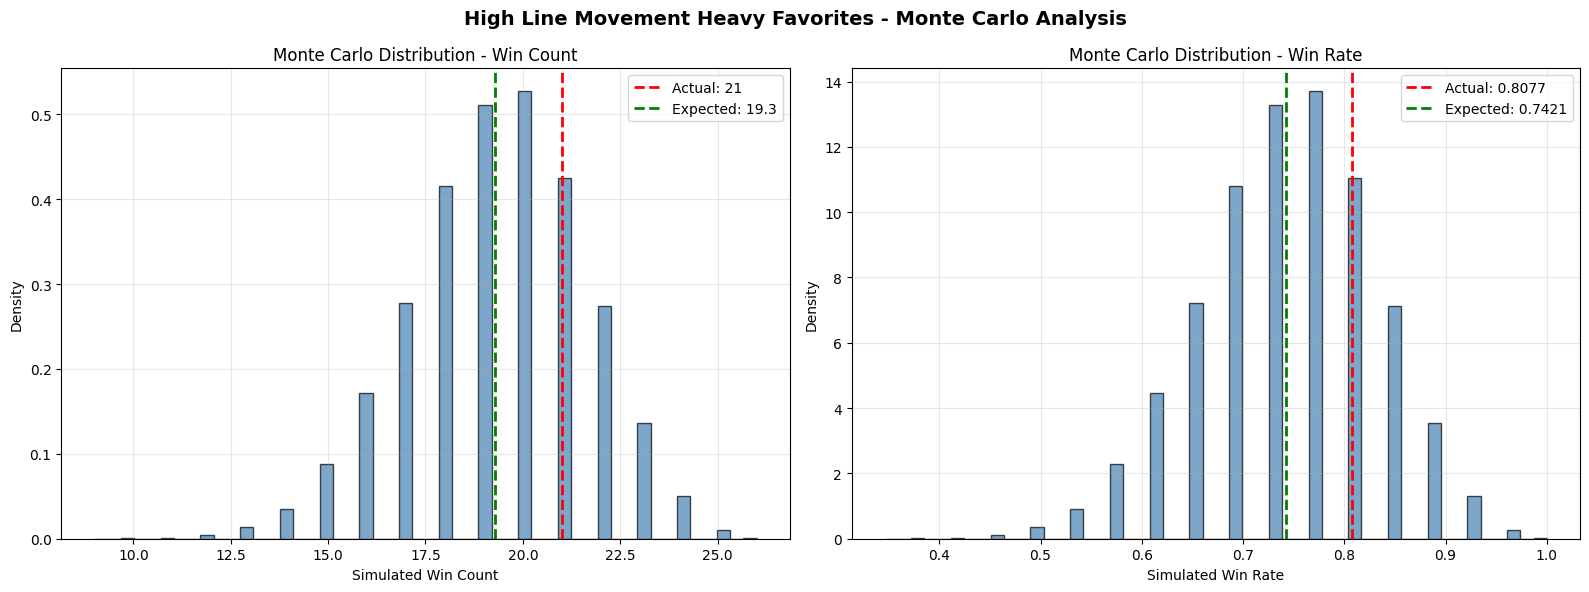


Visualization saved as 'btb_high_movement_monte_carlo.png'.


In [15]:
import matplotlib.pyplot as plt
import numpy as np

print("Monte Carlo Visualization for High-Movement Heavy Favorites")
print("=" * 60)

# Use dfgr_high_movement if heavy_favs_test is not available
HEAVY_FAV_THRESHOLD = 1.40

if 'dfgr_high_movement' in dir() and len(dfgr_high_movement) > 0:
    # Create heavy_favs_test if not exists
    heavy_favs_test = dfgr_high_movement[dfgr_high_movement["FavOdds"] < HEAVY_FAV_THRESHOLD].copy()
    
    p = heavy_favs_test["pFav_win"].clip(1e-6, 1-1e-6).to_numpy()
    actual = heavy_favs_test["FavCorrect"].astype(int).to_numpy()

    n = len(p)
    actual_win_rate = actual.mean()

    print(f"High-movement heavy favorites: {n:,} matches")
    print(f"Actual win rate:               {actual_win_rate:.4f}")
    print(f"Expected win rate:             {p.mean():.4f}")

    # Monte Carlo
    rng = np.random.default_rng(42)
    N_SIMS = 20000

    sim_wins = rng.binomial(1, p, size=(N_SIMS, n)).sum(axis=1)
    sim_win_rate = sim_wins / n

    print(f"\nSimulated mean: {sim_win_rate.mean():.4f}")
    print(f"Simulated std:  {sim_win_rate.std():.4f}")

    # Percentile
    percentile = float((sim_win_rate < actual_win_rate).mean() * 100)
    print(f"Actual value percentile: {percentile:.1f}th percentile")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('High Line Movement Heavy Favorites - Monte Carlo Analysis', fontsize=14, fontweight='bold')

    # Left panel: Win count distribution
    axes[0].hist(sim_wins, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(actual.sum(), color='red', linestyle='--', linewidth=2, label=f'Actual: {actual.sum()}')
    axes[0].axvline(p.sum(), color='green', linestyle='--', linewidth=2, label=f'Expected: {p.sum():.1f}')
    axes[0].set_xlabel('Simulated Win Count')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Monte Carlo Distribution - Win Count')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Right panel: Win rate distribution
    axes[1].hist(sim_win_rate, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    axes[1].axvline(actual_win_rate, color='red', linestyle='--', linewidth=2, label=f'Actual: {actual_win_rate:.4f}')
    axes[1].axvline(p.mean(), color='green', linestyle='--', linewidth=2, label=f'Expected: {p.mean():.4f}')
    axes[1].set_xlabel('Simulated Win Rate')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Monte Carlo Distribution - Win Rate')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('btb_high_movement_monte_carlo.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nVisualization saved as 'btb_high_movement_monte_carlo.png'.")
else:
    print("ERROR: dfgr_high_movement not found. Please run the previous cells first.")

## 3.2 Kolmogorov-Smirnov Test for Distribution Comparison

This section performs a Kolmogorov-Smirnov (KS) test to evaluate whether the empirical distribution of favorite outcomes in high-movement matches matches the theoretical distribution predicted by closing odds probabilities.

### Hypotheses:

**Null Hypothesis (H₀):** The empirical distribution of favorite wins follows the theoretical distribution based on market closing probabilities
- Formally: The cumulative distribution function (CDF) of observed outcomes matches the expected CDF from market odds

**Alternative Hypothesis (H₁):** The empirical distribution significantly differs from the theoretical distribution
- This indicates systematic market inefficiency in high line-movement scenarios

### Methodology:
- **Test Type:** Two-sample Kolmogorov-Smirnov test comparing empirical vs theoretical distributions
- **Test Statistic:** Maximum distance between empirical CDF and theoretical CDF
- **Sample:** High line-movement matches (above 70th percentile)
- **Theoretical Distribution:** Derived from closing odds probabilities
- **Significance Level:** α = 0.05

In [16]:
import numpy as np
import pandas as pd
from scipy import stats

print("Kolmogorov-Smirnov Test for High-Movement Matches")
print("=" * 80)

# Use high-movement matches data
if 'dfgr_high_movement' not in dir() or len(dfgr_high_movement) == 0:
    print("ERROR: dfgr_high_movement not found. Please run previous cells first.")
else:
    # Prepare data
    df_ks = dfgr_high_movement.copy()
    
    # Sort by expected win probability
    df_ks = df_ks.sort_values('pFav_win').reset_index(drop=True)
    
    n_matches = len(df_ks)
    print(f"Total high-movement matches: {n_matches:,}")
    print(f"Expected win rate (mean):    {df_ks['pFav_win'].mean():.4f}")
    print(f"Actual win rate (mean):      {df_ks['FavCorrect'].mean():.4f}")
    
    # For KS test, we'll use the probabilities directly as theoretical distribution
    theoretical_probs = df_ks['pFav_win'].values
    actual_outcomes = df_ks['FavCorrect'].values
    
    # Generate theoretical samples based on market probabilities
    rng = np.random.default_rng(42)
    N_SIMS = 1000
    
    # Perform two-sample KS test
    # Generate theoretical samples based on each match's probability
    theoretical_samples = []
    for _ in range(N_SIMS):
        sample = rng.binomial(1, theoretical_probs)  # Returns array of same shape as theoretical_probs
        theoretical_samples.extend(sample)
    
    theoretical_samples = np.array(theoretical_samples)
    
    # Calculate KS statistic comparing actual vs theoretical distributions
    ks_stat, p_value = stats.ks_2samp(actual_outcomes, theoretical_samples)
    
    print(f"\n" + "=" * 80)
    print("Kolmogorov-Smirnov Test Results")
    print("=" * 80)
    print(f"KS Statistic:     {ks_stat:.6f}")
    print(f"P-value:          {p_value:.6f}")
    
    # Alternative analysis: compare cumulative distributions by probability bins
    n_bins = min(10, n_matches // 5)  # Ensure enough samples per bin
    if n_bins >= 2:
        df_ks['prob_bin'] = pd.qcut(df_ks['pFav_win'], q=n_bins, duplicates='drop')
        
        bin_analysis = df_ks.groupby('prob_bin', observed=True).agg(
            N_Matches=('FavCorrect', 'count'),
            Expected_WinRate=('pFav_win', 'mean'),
            Actual_WinRate=('FavCorrect', 'mean'),
            Expected_Wins=('pFav_win', 'sum'),
            Actual_Wins=('FavCorrect', 'sum')
        ).round(4)
        
        bin_analysis['Difference'] = (bin_analysis['Actual_WinRate'] - bin_analysis['Expected_WinRate']).round(4)
        bin_analysis['Abs_Difference'] = bin_analysis['Difference'].abs()
        
        print(f"\n" + "=" * 80)
        print("Distribution Comparison by Probability Bins")
        print("=" * 80)
        display(bin_analysis)
        
        # Maximum deviation in bins
        max_deviation = bin_analysis['Abs_Difference'].max()
        max_deviation_bin = bin_analysis['Abs_Difference'].idxmax()
        
        print(f"\nMaximum deviation: {max_deviation:.4f} in bin {max_deviation_bin}")
    
    # Interpretation
    ALPHA = 0.05
    print(f"\n" + "=" * 80)
    print(f"Interpretation (alpha={ALPHA})")
    print("=" * 80)
    
    if p_value < ALPHA:
        print(f"[X] Reject H0 (p={p_value:.6f} < {ALPHA})")
        print("The empirical distribution SIGNIFICANTLY DIFFERS from theoretical distribution")
        print("High-movement matches show systematic deviation from market expectations")
    else:
        print(f"[OK] Fail to Reject H0 (p={p_value:.6f} >= {ALPHA})")
        print("No significant difference between empirical and theoretical distributions")
        print("High-movement matches perform consistent with market closing odds")
    
    # Effect size interpretation
    if ks_stat < 0.1:
        effect = "negligible"
    elif ks_stat < 0.3:
        effect = "small"
    elif ks_stat < 0.5:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"\nEffect size interpretation: {effect} (KS statistic = {ks_stat:.4f})")

Kolmogorov-Smirnov Test for High-Movement Matches
Total high-movement matches: 62
Expected win rate (mean):    0.6342
Actual win rate (mean):      0.6613

Kolmogorov-Smirnov Test Results
KS Statistic:     0.026403
P-value:          1.000000

Distribution Comparison by Probability Bins


,N_Matches,Expected_WinRate,Actual_WinRate,Expected_Wins,Actual_Wins,Difference,Abs_Difference
prob_bin,,,,,,,
"(0.317, 0.484]",7,0.4168,0.5714,2.9176,4,0.1546,0.1546
"(0.484, 0.538]",6,0.5128,0.3333,3.0771,2,-0.1795,0.1795
"(0.538, 0.579]",6,0.5611,0.3333,3.3665,2,-0.2278,0.2278
"(0.579, 0.624]",6,0.5973,0.8333,3.5838,5,0.2360,0.2360
"(0.624, 0.648]",6,0.6285,0.6667,3.7712,4,0.0382,0.0382
"(0.648, 0.678]",6,0.6638,0.6667,3.9827,4,0.0029,0.0029
"(0.678, 0.712]",6,0.6942,0.8333,4.1654,5,0.1391,0.1391
"(0.712, 0.738]",6,0.7229,0.8333,4.3373,5,0.1104,0.1104
"(0.738, 0.774]",6,0.7573,0.8333,4.5435,5,0.0760,0.0760



Maximum deviation: 0.2360 in bin (0.579, 0.624]

Interpretation (alpha=0.05)
[OK] Fail to Reject H0 (p=1.000000 >= 0.05)
No significant difference between empirical and theoretical distributions
High-movement matches perform consistent with market closing odds

Effect size interpretation: negligible (KS statistic = 0.0264)


Kolmogorov-Smirnov Test Visualization


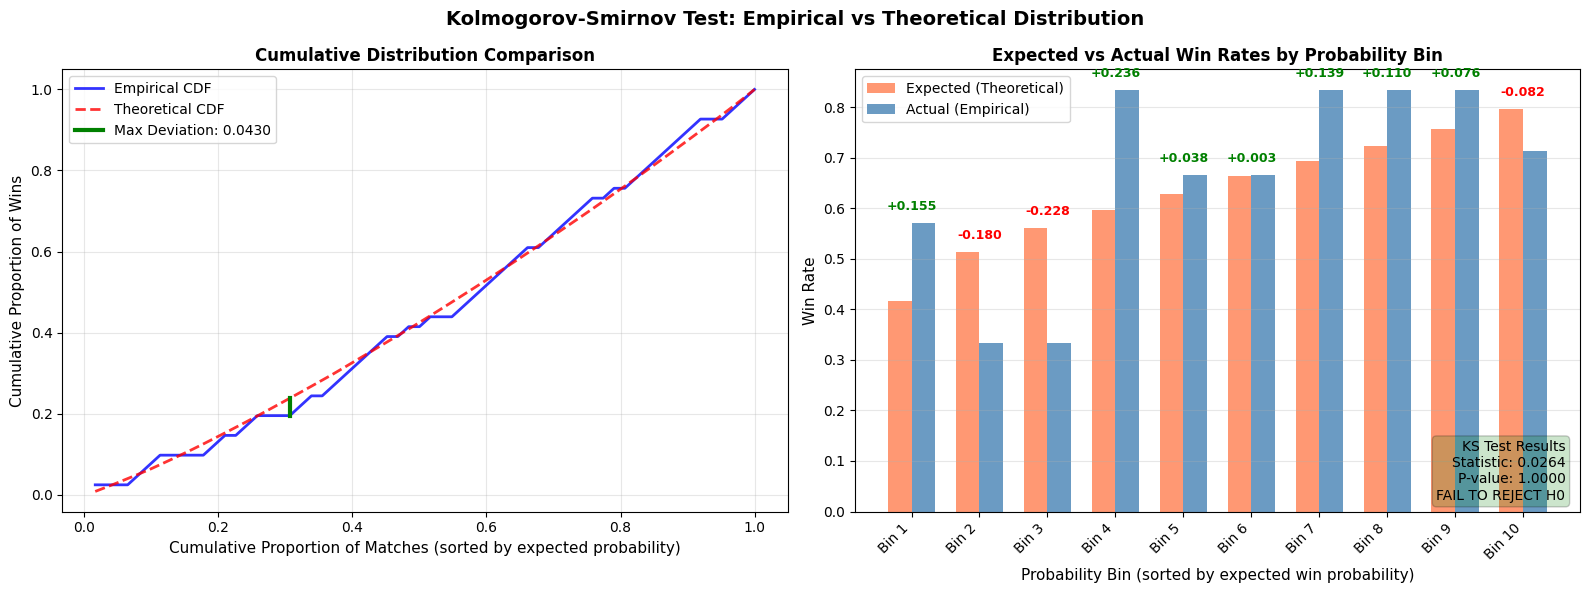


Visualization saved: ks_test_distribution_comparison.png


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

print("Kolmogorov-Smirnov Test Visualization")
print("=" * 60)

if 'dfgr_high_movement' in dir() and len(dfgr_high_movement) > 0:
    # Prepare data
    df_viz = dfgr_high_movement.sort_values('pFav_win').reset_index(drop=True)
    
    theoretical_probs = df_viz['pFav_win'].values
    actual_outcomes = df_viz['FavCorrect'].values
    n = len(df_viz)
    
    # Recalculate KS statistics for visualization
    rng = np.random.default_rng(42)
    N_SIMS = 1000
    theoretical_samples = []
    for _ in range(N_SIMS):
        sample = rng.binomial(1, theoretical_probs)
        theoretical_samples.extend(sample)
    theoretical_samples = np.array(theoretical_samples)
    ks_stat, p_value = stats.ks_2samp(actual_outcomes, theoretical_samples)
    
    # Calculate cumulative distributions
    x_theoretical = np.arange(1, n + 1) / n
    
    # Empirical CDF: cumulative actual wins
    empirical_cumsum = np.cumsum(actual_outcomes) / actual_outcomes.sum() if actual_outcomes.sum() > 0 else np.zeros(n)
    
    # Theoretical CDF: cumulative expected wins
    theoretical_cumsum = np.cumsum(theoretical_probs) / theoretical_probs.sum()
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Kolmogorov-Smirnov Test: Empirical vs Theoretical Distribution', 
                 fontsize=14, fontweight='bold')
    
    # Left panel: Cumulative Distribution Functions
    axes[0].plot(x_theoretical, empirical_cumsum, 'b-', linewidth=2, label='Empirical CDF', alpha=0.8)
    axes[0].plot(x_theoretical, theoretical_cumsum, 'r--', linewidth=2, label='Theoretical CDF', alpha=0.8)
    
    # Mark maximum deviation
    max_diff_idx = np.argmax(np.abs(empirical_cumsum - theoretical_cumsum))
    max_diff = empirical_cumsum[max_diff_idx] - theoretical_cumsum[max_diff_idx]
    
    axes[0].plot([x_theoretical[max_diff_idx], x_theoretical[max_diff_idx]], 
                [empirical_cumsum[max_diff_idx], theoretical_cumsum[max_diff_idx]], 
                'g-', linewidth=3, label=f'Max Deviation: {abs(max_diff):.4f}')
    
    axes[0].set_xlabel('Cumulative Proportion of Matches (sorted by expected probability)', fontsize=11)
    axes[0].set_ylabel('Cumulative Proportion of Wins', fontsize=11)
    axes[0].set_title('Cumulative Distribution Comparison', fontsize=12, fontweight='bold')
    axes[0].legend(loc='upper left')
    axes[0].grid(alpha=0.3)
    
    # Right panel: Win rates by probability bins
    n_bins = min(10, n // 5) if n >= 10 else max(2, n // 3)
    if n_bins >= 2:
        df_viz['prob_bin'] = pd.qcut(df_viz['pFav_win'], q=n_bins, duplicates='drop', labels=False)
        
        bin_stats = df_viz.groupby('prob_bin').agg(
            Expected=('pFav_win', 'mean'),
            Actual=('FavCorrect', 'mean'),
            Count=('FavCorrect', 'count')
        ).reset_index()
        
        x_pos = np.arange(len(bin_stats))
        width = 0.35
        
        bars1 = axes[1].bar(x_pos - width/2, bin_stats['Expected'], width, 
                           label='Expected (Theoretical)', alpha=0.8, color='coral')
        bars2 = axes[1].bar(x_pos + width/2, bin_stats['Actual'], width, 
                           label='Actual (Empirical)', alpha=0.8, color='steelblue')
        
        # Add difference annotations
        for i, (exp, act) in enumerate(zip(bin_stats['Expected'], bin_stats['Actual'])):
            diff = act - exp
            y_pos = max(exp, act) + 0.02
            color = 'green' if diff > 0 else 'red'
            axes[1].text(i, y_pos, f'{diff:+.3f}', ha='center', va='bottom', 
                        fontsize=9, color=color, fontweight='bold')
        
        axes[1].set_xlabel('Probability Bin (sorted by expected win probability)', fontsize=11)
        axes[1].set_ylabel('Win Rate', fontsize=11)
        axes[1].set_title('Expected vs Actual Win Rates by Probability Bin', fontsize=12, fontweight='bold')
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels([f'Bin {i+1}' for i in range(len(bin_stats))], rotation=45, ha='right')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, f'Not enough data for bins\n(n={n})', 
                    ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
        axes[1].set_title('Win Rates by Probability Bin', fontsize=12, fontweight='bold')
    
    # Add test result text
    result_text = f"KS Test Results\n"
    result_text += f"Statistic: {ks_stat:.4f}\n"
    result_text += f"P-value: {p_value:.4f}\n"
    result_text += "REJECT H0" if p_value < 0.05 else "FAIL TO REJECT H0"
    result_color = "red" if p_value < 0.05 else "green"
    
    axes[1].text(0.98, 0.02, result_text, transform=axes[1].transAxes, 
                fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor=result_color, alpha=0.2))
    
    plt.tight_layout()
    plt.savefig('ks_test_distribution_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved: ks_test_distribution_comparison.png")
    
else:
    print("ERROR: dfgr_high_movement not found. Please run previous cells first.")